# DDH2 Demo

### Outline

- Demo Search API endpoint
- Access DDH2 in-built API for CSV/Excel data
- Use ESRI Feature Services to query data
- Demo Cloud Optimized Geotiffs

In [1]:
import csv
import sys
import shapely
import requests
from shapely.geometry import Point, Polygon
import geopandas as gpd
from time import sleep
import pandas as pd
import pylab as pl
from ipyleaflet import *
#from ipyleaflet import Map, GeoJSON, GeoData, Marker, Popup
sys.path.append("../ddh2api")
import ddh2
from config import main
import warnings
warnings.filterwarnings("ignore")
from rio_tiler.io import COGReader
from rio_tiler.utils import create_cutline
from rasterio.features import bounds as featureBounds

In [3]:
#ddhs = ddh2.create_session(cache=True, params = main("Prod"))

### Search dataset via DDH API and use data API to extract information

We'll try to look for [Global Airports](https://datacatalog1.worldbank.org/search/dataset/0038117/Global-Airports) dataset using DDH Search API endpoint

In [4]:
### Searching for datatset

search_list = []
for ds in ddhs.dataset.search("Global Airports"):
    search_list.append(ds)

In [5]:
ds = search_list[0]
print(ds['name'])

Global Airports


In [6]:
### Accessing the in-built DDH2 resource file API to use for analysis

index = ds['Resources'][0]['url'].index("versionId") + 10
airport_data = ddhs.get("resource/preview", params = {"resourceId" :ds['Resources'][0]['resource_id'],
                                                      "versionId" : ds['Resources'][0]['url'][index:], "rowLimit" : 1000}).json()['Details']

df = pd.DataFrame(columns = airport_data[0].keys())

In [7]:
### Converting data into GeoDataframe

for x in airport_data:
    df = df.append(x, ignore_index=True)
    
df.Airport1Latitude = df.Airport1Latitude.astype(float)
df.Airport1Longitude = df.Airport1Longitude.astype(float)
df = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.Airport1Longitude, df.Airport1Latitude))

df.crs = {'init': 'epsg:4326'}

In [8]:
### Visualizing data

m = Map(center = (0, 0), zoom = 2, basemap = basemaps.Esri.DeLorme, scroll_wheel_zoom = True)
geo_data = GeoData(geo_dataframe = df,
    style={'color': 'black', 'radius':5, 'fillColor': '#3366cc', 'opacity':0.5, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
    hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
    point_style={'radius': 3, 'color': 'red', 'fillOpacity': 0.8, 'fillColor': 'blue', 'weight': 3},
    name = 'Global Airports')

m.add_layer(geo_data)
m


Map(center=[0, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

### Access Feature Services from ArcGIS and query data

In [9]:
def get_boundaries(attr, val):
    """
    This function queries World Bank official boundary dataset and returns 
    country boundary based on attribute and value passed to the function. 
    
    Input:
    attr: One of the attributes of database
    val : Value corresponding to the attribute
    
    Complete list of attributes can be found here: 
    https://services.arcgis.com/iQ1dY19aHwbSDYIF/ArcGIS/rest/services/World_Bank_Official_Boundaries_World_Country_Polygons_(Very_High_Definition)/FeatureServer/0
    
    Returns:
    A dataframe with features and geometry returned by the API. 
    """
    
    url = ''.join(['https://services.arcgis.com/iQ1dY19aHwbSDYIF/ArcGIS/rest/services/',
            'World_Bank_Official_Boundaries_World_Country_Polygons_(Very_High_Definition)/FeatureServer/0/query?',
            "where={a}='{b}'&f=pjson&returnGeometry=true&outFields=*&outSR=4326".format(a=attr, b=val)])

    result = requests.get(url, verify=False)

    if result.status_code == 200:
        try:
            res = result.json()
            df = pd.DataFrame.from_dict(res['features'][0]).T[:-1]
            geom_lis = []
            for i in range(len(res['features'][0]['geometry']['rings'])):
                geom_lis.append(shapely.geometry.Polygon(res['features'][0]['geometry']['rings'][i]))
            geom = shapely.ops.cascaded_union(geom_lis)
            df.loc['attributes', 'rings'] = geom
            return df
        except Exception as e:
            return e.args[0]


In [10]:
list_con = ['USA', 'IND', 'CHN', 'GBR', 'NGA', 'COD', 'AUS']

In [11]:
gdf = pd.DataFrame()
for name in list_con:
    
    df = get_boundaries('ISO_A3', name)
    
    if isinstance(df, pd.DataFrame):
        gdf = pd.concat([gdf, df])
    elif isinstance(df, str):
        country = san_fac.loc[name, 'Country']
        df = get_boundaries('WB_NAME', country)
        if isinstance(df, pd.DataFrame):
            gdf = pd.concat([gdf, df])
        else:
            print(name)
            

gdf = gpd.GeoDataFrame(gdf, geometry = 'rings')

In [12]:
m = Map(center=(0, 1), zoom = 2, basemap= basemaps.OpenStreetMap.BlackAndWhite)
geo_data = GeoData(geo_dataframe = gdf,
                   style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.05, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                   name = 'Countries')
m.add_layer(geo_data)
m

Map(center=[0, 1], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text'…

In [12]:
### Plot data

#gdf.plot(color='lightblue', figsize=[20,10])
#pl.axis('off');

### Cloud Optimized GeoTiffs

- A Cloud Optimized GeoTIFF (COG) is a regular GeoTIFF file, aimed at being hosted on a HTTP file server, with an internal organization that enables more efficient workflows on the cloud. It does this by leveraging the ability of clients issuing HTTP GET range requests to ask for just the parts of a file they need.
- Works for TIF file and any vector feature can be used to subset the data (point, polygon, GeoJSON file etc.)

We're reading [Global Landslide Hazard map](https://datacatalog1.worldbank.org/search/dataset/0023254/Global-landslide-hazard-map) from World Bank's Data Catalog

In [13]:
path = "https://development-data-hub-s3-public.s3.amazonaws.com/ddhfiles/1191621/ls_eq_tiled.tif"
point = (72.872314453125,19.132194334419058)
with COGReader(path) as cog:
    img = cog.point(72.872314453125,19.132194334419058)

print("Pixel value for pixel intersecting with point {} is {}".format(point, img))

Pixel value for pixel intersecting with point (72.872314453125, 19.132194334419058) is [2.9999999242136255e-05]


#### You can also subset this data for a country. Here's we're clipping the data to Nepal's borders

In [14]:
df = get_boundaries('ISO_A3', 'NPL')
gdf = gpd.GeoDataFrame(df, geometry = 'rings')

In [15]:
pol = gdf.rings.iloc[0]
with COGReader(path) as cog:
    data, mask = cog.part(pol.bounds, max_size=None)

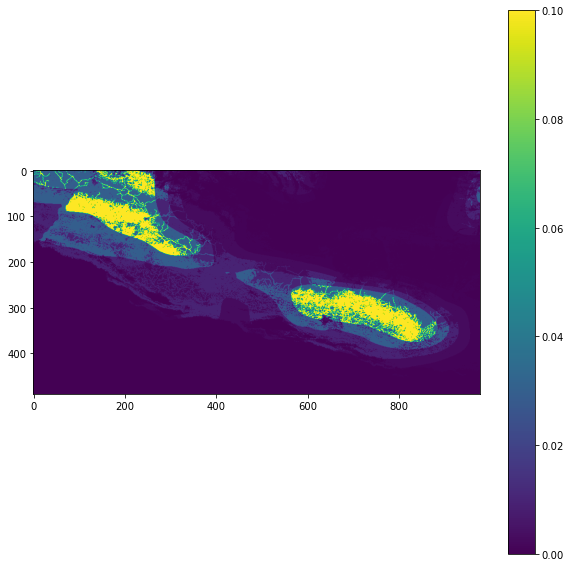

In [16]:
pl.figure(figsize=[10,10])
pl.imshow(data[0,:,:])
pl.colorbar();